In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, Input, Lambda, Conv2D, MaxPooling2D,BatchNormalization, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

In [2]:
#get the train images from file location and add them to the numpy array
image_dir = 'D:/FYP/RAF-ML/Images/allimages'

target_size = (100, 100)

train_images = np.zeros((3926, target_size[0], target_size[1], 3), dtype=np.uint8)
test_images = np.zeros((982, target_size[0], target_size[1], 3), dtype=np.uint8)

train_labels = np.zeros((3926, 6), dtype=np.uint8)
test_labels = np.zeros((982, 6), dtype=np.uint8)

i = 0
j = 0

with open('D:/FYP/RAF-ML/partition_label.txt') as f:
    for line in f:
        file_name, partition = line.strip().split()
        image_name, image_ex = file_name.strip().split(".")
        source = os.path.join(image_dir, image_name + "_aligned." + image_ex)
        if(partition == "0"):
            image = cv2.imread(source)
            image = cv2.resize(image, target_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            train_images[i] = image
            with open('D:/FYP/RAF-ML/multilabel.txt', 'r') as f:
                lines = f.readlines()
                for line in lines:
                    values = line.split()
                    if(values[0]== file_name):
                        train_labels[i] = [int(val) for val in values[1:]]      
                i = i + 1
        else:
            image = cv2.imread(source)
            image = cv2.resize(image, target_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            test_images[j] = image
            with open('D:/FYP/RAF-ML/multilabel.txt', 'r') as f:
                lines = f.readlines()
                for line in lines:
                    values = line.split()
                    if(values[0]== file_name):
                        test_labels[j] = [int(val) for val in values[1:]]   
            j = j + 1


print(train_images.shape)
print(test_images.shape)

print(train_labels.shape)
print(test_labels.shape)

(3926, 100, 100, 3)
(982, 100, 100, 3)
(3926, 6)
(982, 6)


In [3]:
height = 100
width = 100
class_no = 6
categories = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']

In [4]:
model_1 = load_model('ResNet50_Model.h5')
model_2 = load_model('Vgg19_Model.h5')

In [5]:
for layer in model_1.layers:
    layer.trainable = False
    layer._name = 'e_m_1_' + layer.name
for layer in model_2.layers:
    layer.trainable = False
    layer._name = 'e_m_2_' + layer.name

In [6]:
output_1 = model_1.layers[-2].output
output_2 = model_2.layers[-2].output

In [7]:
ensemble_output = tf.keras.layers.Average()([output_1, output_2])
dense_layer = Dense(64, activation='relu')(ensemble_output)
output = Dense(6, activation='sigmoid')(dense_layer)
ensemble_model = Model(inputs=[model_1.input, model_2.input], outputs=output)

In [8]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lambda_1_input (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 e_m_2_lambda_1 (Lambda)        (None, 100, 100, 3)  0           ['lambda_1_input[0][0]']         
                                                                                                  
 e_m_2_vgg19 (Functional)       (None, 512)          20024384    ['e_m_2_lambda_1[0][0]']         
                                                                                                  
 lambda_input (InputLayer)      [(None, 100, 100, 3  0           []                           

                                                                                                  
Total params: 44,064,582
Trainable params: 2,502
Non-trainable params: 44,062,080
__________________________________________________________________________________________________


In [9]:
ensemble_model.compile(optimizer=Adam(learning_rate=0.1),loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
Ensemble_train = ensemble_model.fit(
    [train_images, train_images],
    train_labels, 
    epochs=5,
    batch_size = 64,
    validation_data=([test_images,test_images], test_labels)
)

Epoch 1/5
62/62 [==============================] - 279s 5s/step - loss: 0.5167 - accuracy: 0.7028 - val_loss: 0.5343 - val_accuracy: 0.6802
Epoch 2/5
62/62 [==============================] - 292s 5s/step - loss: 0.5216 - accuracy: 0.6905 - val_loss: 0.5288 - val_accuracy: 0.6884
Epoch 3/5
62/62 [==============================] - 286s 5s/step - loss: 0.5217 - accuracy: 0.7017 - val_loss: 0.5256 - val_accuracy: 0.6965
Epoch 4/5
62/62 [==============================] - 285s 5s/step - loss: 0.5203 - accuracy: 0.6913 - val_loss: 0.5222 - val_accuracy: 0.6843
Epoch 5/5
62/62 [==============================] - 283s 5s/step - loss: 0.5196 - accuracy: 0.6997 - val_loss: 0.5264 - val_accuracy: 0.7057


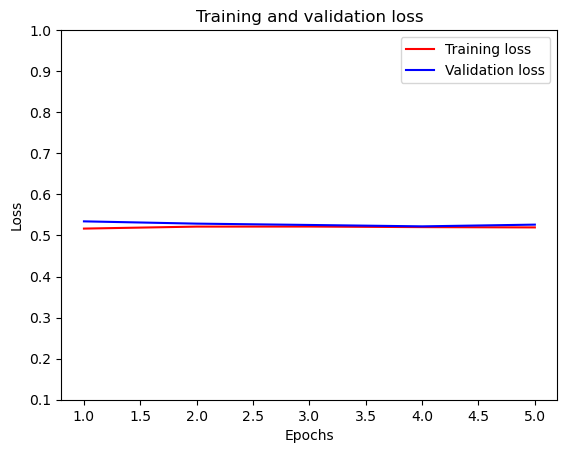

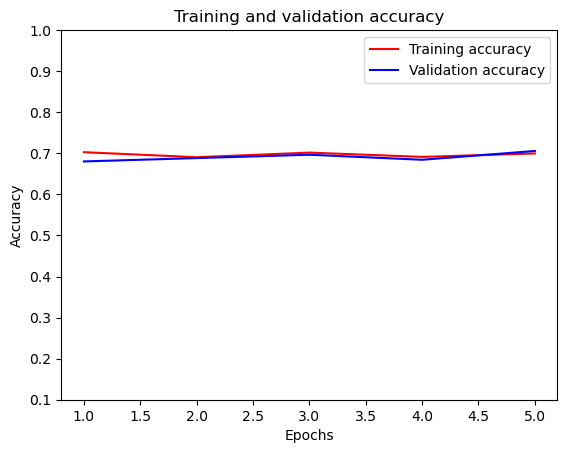

In [14]:
loss = Ensemble_train.history['loss']
acc = Ensemble_train.history['accuracy']
val_loss = Ensemble_train.history['val_loss']
val_acc = Ensemble_train.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# plot the training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.axis(ymin=0.1,ymax=1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.axis(ymin=0.1,ymax=1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluation Metrics

In [20]:
from sklearn.metrics import classification_report


predictions = ensemble_model.predict([test_images, test_images])

predictions = (predictions > 0.5).astype(int)

report = classification_report(test_labels, predictions, target_names=categories)

# print the report
print(report)


31/31 [==============================] - 51s 2s/step
              precision    recall  f1-score   support

    Surprise       0.74      0.67      0.71       408
        Fear       0.69      0.37      0.48       232
     Disgust       0.80      0.84      0.82       539
   Happiness       0.69      0.09      0.15       258
     Sadness       0.48      0.14      0.22       343
       Anger       0.73      0.06      0.12       384

   micro avg       0.74      0.42      0.54      2164
   macro avg       0.69      0.36      0.42      2164
weighted avg       0.70      0.42      0.46      2164
 samples avg       0.73      0.43      0.52      2164



D:\Applications\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import hamming_loss

hl = hamming_loss(test_labels, predictions)
print("Hamming Loss:", hl)

Hamming Loss: 0.2671418873048201


In [19]:
ensemble_model.save("Ensemble_Avarage.h5")

## Upload and Test Images

1/1 [==============================] - 1s 1s/step
Surprise, Fear


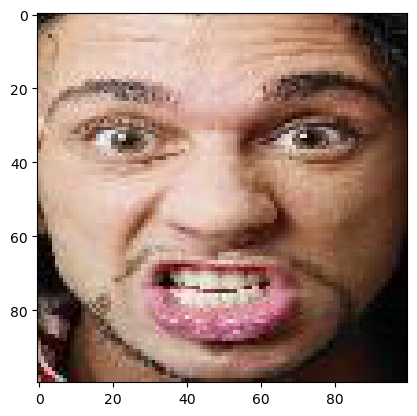

In [30]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

categories = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']

model = load_model('Ensemble_Avarage.h5')
#img_path = 'C:/Users/User/Downloads/face3.jpg'
img_path = 'D:/FYP/RAF-ML/Images/allimages/1100_aligned.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(100, 100))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict([x,x])

threshold = 0.4
labels = []
for i, prob in enumerate(preds[0]):
    if prob > threshold:
        labels.append(categories[i])

if len(labels) > 0:
    result = ', '.join(labels)
else:
    result = "Invalid image"
plt.imshow(img)
print(result)